In [1]:
import json
import glob
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
DATA_DIR = "../data/" 
AUGMENTATION_FACTOR = 10 # Adjusted for file-split (prevents overfitting on specific files)
BATCH_SIZE = 32

In [3]:
def extract_features(line_json):
    try:
        data = json.loads(line_json)
        
        # --- A. Thermal Image (8x24) ---
        if 'left' not in data['thermal']: return None, None
        
        img_left = np.array(data['thermal']['left'], dtype=np.float32).reshape(8, 8)
        img_center = np.array(data['thermal']['center'], dtype=np.float32).reshape(8, 8)
        img_right = np.array(data['thermal']['right'], dtype=np.float32).reshape(8, 8)
        
        # Stitch: (8, 24)
        full_img = np.concatenate([img_left, img_center, img_right], axis=1)
        
        # --- FIX: Per-Frame Normalization ---
        # Instead of global stats, we subtract THIS frame's mean.
        # This highlights relative heat spots regardless of ambient temp (10C vs 30C).
        frame_mean = np.mean(full_img)
        full_img = full_img - frame_mean
        
        img_feat = np.expand_dims(full_img, axis=-1)

        # --- B. Scalars (Radar + Mic) ---
        scalars = []
        radar_source = data.get('mmWave', data.get('radar', {}))
        r1 = radar_source.get('R1', radar_source.get('left', {}))
        r2 = radar_source.get('R2', radar_source.get('right', {}))

        # Radar Features
        scalars.extend([r1.get('energy',0), float(r1.get('range',0)), float(r1.get('speed',0))])
        scalars.extend([r2.get('energy',0), float(r2.get('range',0)), float(r2.get('speed',0))])
        
        # Mic Features
        mic = data.get('mic', {})
        scalars.append(mic.get('left', 0.0))
        scalars.append(mic.get('right', 0.0))
        
        return img_feat, np.array(scalars, dtype=np.float32)
        
    except Exception:
        return None, None

In [4]:
# ==========================================
# 3. ROBUST DATA LOADING (FILE-BASED SPLIT)
# ==========================================
print("--- 1. Organizing Files ---")
files_neg = glob.glob(os.path.join(DATA_DIR, "data_label_0*.jsonl"))
files_pos = glob.glob(os.path.join(DATA_DIR, "data_label_1*.jsonl"))

# Shuffle files first
random.seed(42)
random.shuffle(files_neg)
random.shuffle(files_pos)

# Split FILES (80/20) - Ensures specific recording sessions are kept separate
split_idx_neg = int(len(files_neg) * 0.8)
split_idx_pos = int(len(files_pos) * 0.8)

train_files = files_neg[:split_idx_neg] + files_pos[:split_idx_pos]
test_files = files_neg[split_idx_neg:] + files_pos[split_idx_pos:]

print(f"📂 Training Files: {len(train_files)}")
print(f"📂 Testing Files:  {len(test_files)}")

def load_dataset_from_files(file_list):
    X_img, X_scal, Y = [], [], []
    for f_path in file_list:
        label = 1.0 if "label_1" in f_path else 0.0
        with open(f_path, 'r') as f:
            for line in f:
                img, scal = extract_features(line)
                if img is not None:
                    X_img.append(img)
                    X_scal.append(scal)
                    Y.append(label)
    return np.array(X_img, dtype=np.float32), np.array(X_scal, dtype=np.float32), np.array(Y, dtype=np.float32)

print("--- 2. Loading Data Content ---")
X_img_train, X_scal_train, y_train = load_dataset_from_files(train_files)
X_img_test, X_scal_test, y_test = load_dataset_from_files(test_files)

print(f"✅ Train Frames: {len(y_train)} | Test Frames: {len(y_test)}")

if len(y_train) == 0:
    print("❌ Error: No training data found.")
    exit()

--- 1. Organizing Files ---
📂 Training Files: 45
📂 Testing Files:  13
--- 2. Loading Data Content ---
✅ Train Frames: 2587 | Test Frames: 958


In [5]:
# ==========================================
# 4. AUGMENTATION & SHUFFLING
# ==========================================
if AUGMENTATION_FACTOR > 0:
    print(f"--- Augmenting Training Data ---")
    aug_img, aug_scal, aug_y = [], [], []
    
    for i in range(len(y_train)):
        aug_img.append(X_img_train[i])
        aug_scal.append(X_scal_train[i])
        aug_y.append(y_train[i])
        
        for _ in range(AUGMENTATION_FACTOR):
            # Thermal Augmentation: Noise Only
            # Note: We don't need Temp Shift anymore because we do per-frame normalization!
            new_img = X_img_train[i].copy()
            new_img += np.random.normal(0, 0.3, new_img.shape) 
            
            # Scalar Augmentation
            new_scal = X_scal_train[i].copy()
            new_scal += np.random.normal(0, 0.05, new_scal.shape)
            
            aug_img.append(new_img)
            aug_scal.append(new_scal)
            aug_y.append(y_train[i])
            
    X_img_train = np.array(aug_img, dtype=np.float32)
    X_scal_train = np.array(aug_scal, dtype=np.float32)
    y_train = np.array(aug_y, dtype=np.float32)

# Shuffle Training Data
X_img_train, X_scal_train, y_train = shuffle(X_img_train, X_scal_train, y_train, random_state=42)

--- Augmenting Training Data ---


In [6]:
# ==========================================
# 5. NORMALIZATION (SCALARS ONLY)
# ==========================================
# Images are already normalized per-frame in extract_features()
# We only need to normalize Scalars globally

mean_scal = np.mean(X_scal_train, axis=0)
std_scal = np.std(X_scal_train, axis=0)
std_scal[std_scal == 0] = 1.0

X_scal_train = (X_scal_train - mean_scal) / std_scal
X_scal_test = (X_scal_test - mean_scal) / std_scal

# Save Header
with open("normalization_values.h", "w") as f:
    f.write("#ifndef NORM_H\n#define NORM_H\n")
    f.write("// NOTE: Thermal images must be Zero-Centered PER FRAME in C++ code.\n")
    f.write("// formula: pixel = pixel - frame_average\n\n")
    f.write("const float SCALAR_MEAN[]={"+",".join([f"{x:.4f}" for x in mean_scal])+"};\n")
    f.write("const float SCALAR_STD[]={"+",".join([f"{x:.4f}" for x in std_scal])+"};\n#endif")

In [7]:
# ==========================================
# 6. MODEL (Regularized & Constrained)
# ==========================================
# Branch 1: Thermal Image (CNN)
input_img = Input(shape=(8, 24, 1), name="thermal")

# Added L2 regularization to force the model to keep weights small
x1 = Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_img)
x1 = MaxPooling2D((2, 2))(x1) 
# Reduced filters from 16 -> 8. A "dumber" model generalizes better.
x1 = Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x1)

x1 = GlobalAveragePooling2D()(x1) 

# Branch 2: Scalars (Dense)
input_scal = Input(shape=(X_scal_train.shape[1],), name="scalars")
# Added L2 here too, as Radar is prone to overfitting
x2 = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(input_scal)
x2 = BatchNormalization()(x2)

# Fusion
combined = Concatenate()([x1, x2])
z = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(combined)

# Increase Dropout slightly
z = Dropout(0.6)(z) 

output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[input_img, input_scal], outputs=output)

In [8]:
# ==========================================
# 7. TRAINING
# ==========================================
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_fn, metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(class_weights))

history = model.fit(
    [X_img_train, X_scal_train], y_train,
    validation_data=([X_img_test, X_scal_test], y_test),
    epochs=20, # Increased epochs since model is simpler
    batch_size=BATCH_SIZE,
    class_weight=cw_dict,
    callbacks=[
        # 1. Save ONLY the best version (Epoch 8 in your case)
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_farm.keras", 
        monitor='val_accuracy', # Watch the Test Accuracy
        save_best_only=True,    # Overwrite only if it gets better
        mode='max',
        verbose=1
    ),
    
    # 2. Fix the "Bouncing": Lower LR when it gets stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,       # Slash LR to 20%
        patience=3,       # Wait 3 epochs before slashing
        min_lr=1e-6,
        verbose=1
    ),
    
    # 3. Stop if it gets worse for too long
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=8, 
        restore_best_weights=True
    )
               ]
)

Epoch 1/20
881/890 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - loss: 0.9445
Epoch 1: val_accuracy improved from None to 0.66180, saving model to best_model_farm.keras
890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 0.8468 - val_accuracy: 0.6618 - val_loss: 0.7127 - learning_rate: 5.0000e-04
Epoch 2/20
859/890 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6550 - loss: 0.7082
Epoch 2: val_accuracy improved from 0.66180 to 0.68267, saving model to best_model_farm.keras
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6726 - loss: 0.6887 - val_accuracy: 0.6827 - val_loss: 0.6452 - learning_rate: 5.0000e-04
Epoch 3/20
858/890 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7071 - loss: 0.6498
Epoch 3: val_accuracy improved from 0.68267 to 0.71921, saving model to best_model_farm.keras
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7132 - loss: 0.6422 - val_accuracy: 0.7192 - val_loss: 0.6112 - learning_rate: 5.0000e-04
Epoch 4/20
864/890 ━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8403 - loss: 0.5210 
Test Accuracy (Unseen Files): 84.03%


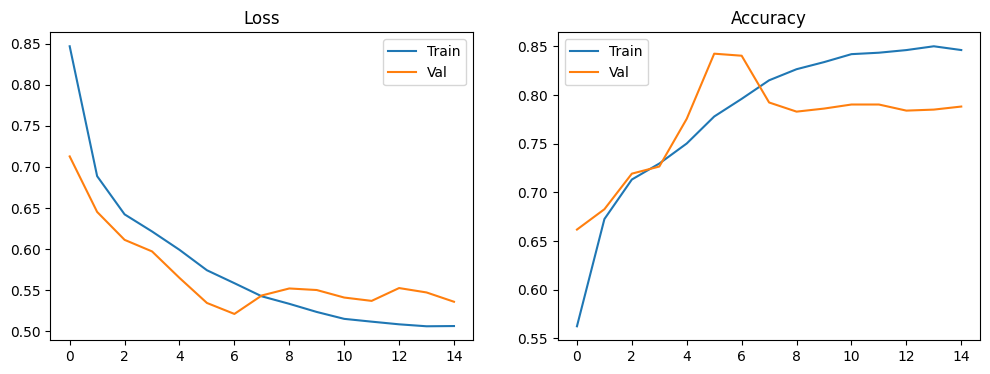

INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpi9wrdbrh/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpi9wrdbrh/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpi9wrdbrh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 8, 24, 1), dtype=tf.float32, name='thermal'), TensorSpec(shape=(None, 8), dtype=tf.float32, name='scalars')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  6007047264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6007047968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034461744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034462448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6007061168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034461392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034465616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034467376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034464912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6034465088: TensorSpec(s

/Users/wanghley/miniconda3/envs/agronaults/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764166338.815289   71318 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764166338.815300   71318 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-26 09:12:18.815521: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpi9wrdbrh
2025-11-26 09:12:18.815984: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-26 09:12:18.815991: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpi9wrdbrh
I0000 00:00:1764166338.819813   71318 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-26 0

✅ Model exported.


s.
2025-11-26 09:12:18.861988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-11-26 09:12:18.905025: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


In [9]:
# ==========================================
# 8. RESULTS & EXPORT
# ==========================================
loss, acc = model.evaluate([X_img_test, X_scal_test], y_test)
print(f"Test Accuracy (Unseen Files): {acc*100:.2f}%")

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.title("Loss"); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Val'); plt.title("Accuracy"); plt.legend()
plt.show()

# TFLite Export
def representative_data_gen():
    for i in range(min(100, len(X_img_train))):
        yield [X_img_train[i:i+1], X_scal_train[i:i+1]]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
with open("model_final.tflite", "wb") as f: f.write(tflite_model)
print("✅ Model exported.")

# Generate C header for model
data = tflite_model
hex_array = ", ".join([f"0x{b:02x}" for b in data])
with open('model.h','w') as f:
    f.write("#ifndef MODEL_H\n#define MODEL_H\n#include <Arduino.h>\n\n")
    f.write(f"alignas(16) const unsigned char model_tflite[] = {{ {hex_array} }};\n")
    f.write(f"const unsigned int model_tflite_len = {len(data)};\n\n#endif\n")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def find_optimal_threshold(model, X_data, y_true, start=0.1, end=0.9, step=0.01):
    """
    Scans thresholds from start to end to find the one that maximizes F1 Score.
    """
    print("--- Scanning for Best Decision Threshold ---")
    
    # 1. Get raw probabilities (0.0 to 1.0)
    # Note: We use the list [X_img, X_scal] because your model is dual-input
    y_pred_prob = model.predict(X_data, verbose=0)
    
    thresholds = np.arange(start, end, step)
    f1_scores = []
    precisions = []
    recalls = []
    accuracies = []
    
    best_thresh = 0.5
    best_f1 = 0.0
    
    for t in thresholds:
        # Apply threshold
        y_pred_bin = (y_pred_prob > t).astype(int)
        
        # Calculate metrics
        f1 = f1_score(y_true, y_pred_bin, zero_division=0)
        prec = precision_score(y_true, y_pred_bin, zero_division=0)
        rec = recall_score(y_true, y_pred_bin, zero_division=0)
        acc = accuracy_score(y_true, y_pred_bin)
        
        f1_scores.append(f1)
        precisions.append(prec)
        recalls.append(rec)
        accuracies.append(acc)
        
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # 2. Print Results
    print(f"✅ Best Threshold (Max F1): {best_thresh:.2f}")
    
    # Get metrics at best threshold
    idx = np.where(thresholds == best_thresh)[0][0]
    print(f"   - F1 Score:  {f1_scores[idx]:.4f}")
    print(f"   - Precision: {precisions[idx]:.4f} (Trustworthiness)")
    print(f"   - Recall:    {recalls[idx]:.4f} (Sensitivity)")
    print(f"   - Accuracy:  {accuracies[idx]:.4f}")

    # 3. Visualize the Trade-off
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision (Low False Positives)', linestyle='--', color='blue')
    plt.plot(thresholds, recalls, label='Recall (Low False Negatives)', linestyle='--', color='green')
    plt.plot(thresholds, f1_scores, label='F1 Score (Balance)', linewidth=3, color='red')
    
    plt.axvline(best_thresh, color='black', linestyle=':', label=f'Best: {best_thresh:.2f}')
    plt.title("Threshold Selection Curve")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_thresh

--- Scanning for Best Decision Threshold ---
✅ Best Threshold (Max F1): 0.49
   - F1 Score:  0.8301
   - Precision: 0.7546 (Trustworthiness)
   - Recall:    0.9225 (Sensitivity)
   - Accuracy:  0.8424


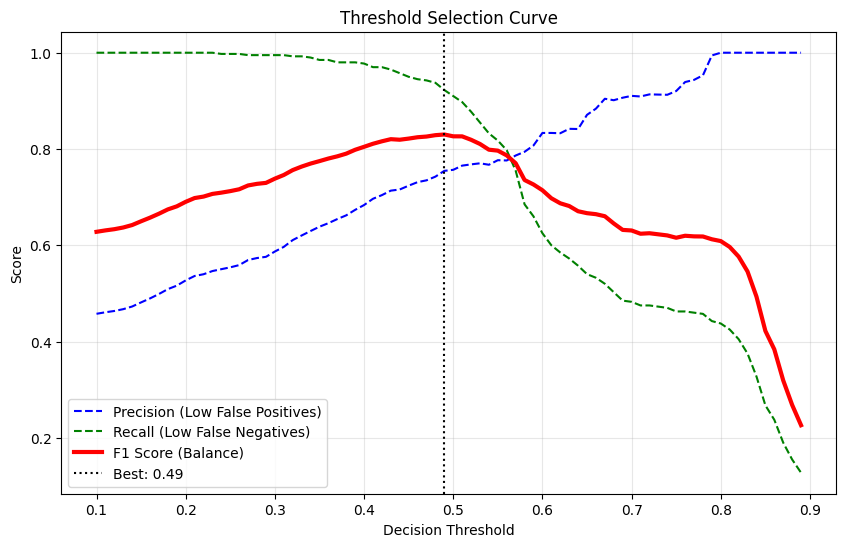

In [11]:
optimal_t = find_optimal_threshold(model, [X_img_test, X_scal_test], y_test)